In [67]:
from sstadex import Macromodel, Primitive, dfs, simplediffpair, cs_pmos, cm_pmos, spice_sim
import numpy as np
from sympy import Symbol
from sympy.solvers import solve
import matplotlib.pyplot as plt
import paretoset as pareto
import pandas as pd
from sympy import lambdify

from sstadex import Transistor
import seaborn as sns
sns.set_theme()
sns.color_palette("mako")


XSCHEM_RCFILE = "/opt/pdks/sky130A/libs.tech/xschem/xschemrc"
SPICE_DIR = "./spice/"
OUTPUT_DIR = "./output/"
XSCHEM_DIR = "./xschem/"

class test:
    def __init__(self, composed = 0, parametros ={}, lamb = None, target_param = ""):
        self.composed = composed
        self.parametros = parametros
        self.lamd = lamb
        self.target_param = target_param
    def eval(funct):
        return {"eval": funct}
    
## Exploration parameters

N_points = 10
lengths = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

## Electrical parameters

Vout = 1.8                                     # LDO output voltage
Vin = 3.3                                      # LDO supply voltage
Vref = 1.35                                     # LDO voltage reference
IL = 100e-3                                      # Load current
CL = 10e-6                                        # Load capacitance
RL = Vout/IL

## LDO specifications
    
psrr_condition = -60
estability_condition = 80
linereg_condition = 0.5
loadreg_condition = 0.7
iq_condition = 20e-6
size_condition = 1e-3

Is1 = 25e-6
Is2 = 25e-6

In [ ]:
## LDO MACROMODEL

Vg = np.linspace(Vin - (Vin - Vout), 2.5, 5)

LDO_macro = Macromodel(name = "ldo",
                       outputs = [Symbol("W_pt"), Symbol("L_pt")],
                       electrical_parameters = {"Vdd": Vin, 
                                                "Vref": Vref, 
                                                "Vout": Vout, 
                                                "Vaout": 1.7,
                                                "Il": IL} 
                       )

LDO_macro.area_conditions = [10e-3, 0]

## 2stage_OTA MACROMODEL

Vg_ota = np.linspace(LDO_macro.electrical_parameters["Vdd"] - (LDO_macro.electrical_parameters["Vdd"] - LDO_macro.electrical_parameters["Vaout"]), LDO_macro.electrical_parameters["Vdd"], 5)

stage2_OTA_macro = Macromodel(name = "stage2_OTA",
                              outputs=[Symbol("W_2stage"), Symbol("L_2stage")],
                              macromodel_parameters={Symbol('Ra'): np.logspace(3, 7, N_points),
                                                     Symbol('gma'): np.logspace(-5, -2, N_points),
                                                     Symbol('Ca'): np.logspace(-17, -12, N_points)},
                              electrical_parameters = {"Vdd": LDO_macro.electrical_parameters["Vdd"], 
                                                       "Vneg": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vpos": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vout": LDO_macro.electrical_parameters["Vaout"],
                                                       "Vaouts1": 1.6}
                              )
stage2_OTA_macro.area_conditions = [10e-3, 1, 1, 1]

## 1stage_OTA MACROMODEL

OTA_macro = Macromodel(name = "ota_cap",
                       outputs = [Symbol("W_diff"), Symbol("L_diff"), Symbol("W_aload"), Symbol("L_aload")],
                       req_tfs = [["vout", "vpos"], ["vout", "vpos"]],
                       macromodel_parameters={Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
                                              Symbol('gma_1stage'): np.logspace(-5, -2, N_points),
                                              Symbol('Ca_1stage'): np.logspace(-17, -12, N_points)},
                       electrical_parameters={Symbol("gdif_2"): Symbol("gdif_1"),
                                              Symbol("Rdif_2"): Symbol("Rdif_1")}
                      )

OTA_macro.area_conditions = [10e-3, 1, 1, 1]

In [69]:
## PASS TRANSISTOR MACROMODEL

pt = cs_pmos(netlist='pmos_cm.spice', 
             type='pmos', 
             inputs={'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'vgs_lut': (-2, -0.1, 0.01), 
                     'vgs': LDO_macro.electrical_parameters["Vaout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'il': LDO_macro.electrical_parameters["Il"],
                     'length': lengths, 
                     '2d_var': ['length', 'vgs']})

pt.build()

pt.parameters = {Symbol('gm_pt'): np.asarray(pt.gm).flatten(),
                 Symbol('Ro_pt'): np.asarray(pt.Ro).flatten()}
pt.outputs = {Symbol("W_pt"): np.asarray(pt.W).flatten(),
              Symbol("L_pt"): np.asarray(pt.L).flatten()}

## OTA stage2 transistor MACROMODEL

stage2_t = cs_pmos(netlist='pmos_cm', 
                   type='pmos', 
                   inputs={'vds_lut': stage2_OTA_macro.electrical_parameters["Vout"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                           'vgs_lut': (-2, -0.1, 0.01), 
                           'vgs': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                           'il': Is2,
                           'length': lengths, 
                           '2d_var': ['length', 'vgs']})
stage2_t.build()

stage2_t.parameters = {Symbol('gm_stage2'): np.asarray(stage2_t.gm).flatten(),
                 Symbol('Ro_stage2'): np.asarray(stage2_t.Ro).flatten()}
stage2_t.outputs = {Symbol("W_2stage"): np.asarray(stage2_t.W).flatten(),
                    Symbol("L_2stage"): np.asarray(stage2_t.L).flatten()}

## OTA stage1 differential pair

vs = np.linspace(0.3, 1.25, 20)
vds_diffpar = stage2_OTA_macro.electrical_parameters["Vaouts1"] - vs
vgs_diffpar = stage2_OTA_macro.electrical_parameters["Vpos"] - vs

diffpair_primitive = simplediffpair(netlist='simplediffpair', 
                                    type='nmos', 
                                    inputs={'vds_lut': (0.1, 2, 0.01),
                                            'vgs_lut': (0.1, 2.2, 0.01), 
                                            'vds': vds_diffpar, 
                                            'vgs': vgs_diffpar, 
                                            'il': Is1,
                                            'length': lengths, 
                                            '2d_var': ['vds', 'vgs']})

diffpair_primitive.build()      

diffpair_primitive.parameters = {Symbol("Rdif_1"): np.asarray(diffpair_primitive.Ro).flatten(), 
                                 Symbol("gdif_1"): np.asarray(diffpair_primitive.gm).flatten(),
                                 Symbol("Cgd"): np.asarray(diffpair_primitive.cgd).flatten(),
                                 Symbol("Cgs"): np.asarray(diffpair_primitive.cgs).flatten()}
diffpair_primitive.outputs = {Symbol("W_diff"): np.asarray(diffpair_primitive.W).flatten(),
                              Symbol("L_diff"): np.asarray(diffpair_primitive.L).flatten()}

## OTA stage1 active load

ota_cm_pmos = cm_pmos(name='ota_cm_pmos', 
                      netlist='pmos_cm ', 
                      type='pmos', 
                      inputs={'vds_lut': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                              'vgs_lut': (-1.8, -0.1, 0.01), 
                              'vgs': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                              'il': Is1,
                              'length': lengths, 
                              '2d_var': ['length', 'vgs']})
ota_cm_pmos.build()

ota_cm_pmos.parameters = {Symbol("Raload_1"): np.asarray(ota_cm_pmos.Ro).flatten(),
                          Symbol("gaload"): np.asarray(ota_cm_pmos.gm).flatten()}
ota_cm_pmos.outputs = {Symbol("W_aload"): np.asarray(ota_cm_pmos.W).flatten(),
                       Symbol("L_aload"): np.asarray(ota_cm_pmos.L).flatten()}

length
vgs
0
length
vgs
0
vds
vgs
1
length
vgs
0


In [70]:
print(pt.W[1])
print(pt.gds[1])
print(pt.Ro[1])

[0.00586685]
[0.0015681]
[637.71482188]


In [71]:
## LDO MACROMODEL

#################### PSRR LDO MACRO #######################
psrr_LDO_macro = test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                   Symbol("V2"): 0,
                   Symbol("s"): 0,
                   Symbol("Rl"): RL,
                   Symbol("Cl"): CL,
                   Symbol("Cc"): 1e-12,
                   Symbol("R1"): 100000,
                   Symbol("R2"): 300000}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [10**(-70/20)]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

#################### BW LDO MACRO #######################
bw_LDO_macro = test()
bw_LDO_macro.name = "bw_LDO"
bw_LDO_macro.tf = ["vout", "vdd"]
bw_LDO_macro.netlist = "ldo"
bw_LDO_macro.parametros = {Symbol("V1"): 1,
                  Symbol("V2"): 0,
                  Symbol("Rl"): RL,
                  Symbol("Cl"): CL,
                   Symbol("Cc"): 1e-12,
                  Symbol("R1"): 100000,
                  Symbol("R2"): 300000}
bw_LDO_macro.conditions = {"min": [1e4]}
bw_LDO_macro.variables = {}
bw_LDO_macro.out_def = {"frec": [bw_LDO_macro.tf, -0.70794]}

#################### load regulation LDO MACRO #######################
loadreg_LDO_macro = test()
loadreg_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
loadreg_LDO_macro.parametros = {Symbol("V1"): 1.8,
                      Symbol("V2"): 1.35,
                      Symbol("s"): 0,
                      Symbol("Cl"): CL,
                      Symbol("Cc"): 1e-12,
                      Symbol("R1"): 100000,
                      Symbol("R2"): 300000}
loadreg_LDO_macro.variables = {Symbol('Rl'): [RL, RL+1200]}
loadreg_LDO_macro.out_def = {'diff': [loadreg_LDO_macro.tf, loadreg_LDO_macro.variables]}
loadreg_LDO_macro.conditions = {'max': [1]}

## 2stage_OTA MACROMODEL

#################### PSRR 2 stage OTA #######################
psrr_2stage_OTA = test()
psrr_2stage_OTA.name = "psrr_2stage"
psrr_2stage_OTA.tf = ["vout", "V_p"]
psrr_2stage_OTA.netlist = "stage2_OTA"
psrr_2stage_OTA.parametros = {Symbol("V1"): 0,
                   Symbol("V2"): 1,
                   Symbol("V3"): 0,
                   Symbol("Il"): 0, 
                   Symbol("I2"): 0,
                   Symbol("Cl"): 0,
                   Symbol("s"): 0}

psrr_2stage_OTA.opt_goal = "max"
psrr_2stage_OTA.conditions = {"min": [10**(30/20)]}
psrr_2stage_OTA.variables = {}
psrr_2stage_OTA.out_def = {"eval": psrr_2stage_OTA.tf}
 
#################### BW 2 stage OTA #######################
bw_2stage_OTA = test()
bw_2stage_OTA.name = "bw_2stage"
bw_2stage_OTA.tf = ["vout", "V_p"]
bw_2stage_OTA.netlist = "stage2_OTA"
bw_2stage_OTA.parametros = { Symbol("V1"): 0,
                   Symbol("V2"): 1,
                   Symbol("V3"): 0,
                   Symbol("Il"): 0,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 1e-12}
bw_2stage_OTA.variables = {}
bw_2stage_OTA.out_def = {"eval": bw_2stage_OTA.tf}

#################### rout 2 stage OTA #######################
rout_2stage_OTA = test()
rout_2stage_OTA.name = "rout_2stage"
rout_2stage_OTA.target_param = Symbol("Ra")
rout_2stage_OTA.tf = ["vout", "vr"]
rout_2stage_OTA.netlist = "stage2_OTA_r"
rout_2stage_OTA.parametros = {Symbol("V1"): 0,
                   Symbol("V2"): 0,
                   Symbol("V3"): 0,
                   Symbol("V4"): 1,
                   Symbol("Ra_1"): 1000,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 0,
                   Symbol("s"): 0}
rout_2stage_OTA.opt_goal = "max"
rout_2stage_OTA.conditions = {"min": [4.641589e+02]}
x = Symbol("x")
rout_2stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_2stage_OTA.variables = {}
rout_2stage_OTA.out_def = {"eval": rout_2stage_OTA.tf}

#################### gm 2 stage OTA #######################

gm_2stage_OTA = test()
gm_2stage_OTA.target_param = Symbol("gma")
gm_2stage_OTA.name = "gm_2stage"
gm_2stage_OTA.tf = ["vout", "V_p"]
gm_2stage_OTA.netlist = "stage2_OTA"
gm_2stage_OTA.composed = 1
gm_2stage_OTA.out_def = {"divide": [psrr_2stage_OTA, rout_2stage_OTA]}
gm_2stage_OTA.opt_goal = "max"

gm_2stage_OTA.conditions = {"min": [0.0001]}

## 1stage_OTA MACROMODEL

#################### PSRR 1stage OTa #######################
psrr_1stage_OTA = test()
psrr_1stage_OTA.tf = ("vout", "vpos")
psrr_1stage_OTA.name = "psrr_1stage"
psrr_1stage_OTA.netlist = "ota_cap"
psrr_1stage_OTA.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                   Symbol("Rdif_2"): Symbol("Rdif_1"),
                   Symbol("gaload_2"): Symbol("gaload"),
                   Symbol("Raload_2"): Symbol("Raload_1"),
                   Symbol("V1"): 0,
                   Symbol("V_n"): 0,
                   Symbol("V_p"): 1,
                   Symbol("I2"): 0,
                   Symbol("s"): 0,
                   Symbol("Cl"): 1e-12}
psrr_1stage_OTA.opt_goal = "max"
psrr_1stage_OTA.conditions = {"min": [40]}
psrr_1stage_OTA.variables = {}
psrr_1stage_OTA.out_def = {"eval": psrr_1stage_OTA.tf}

#################### BW 1stage OTA #######################

bw_1stage_OTA = test()
bw_1stage_OTA.tf = ("vout", "vpos")
bw_1stage_OTA.netlist = "ota_cap"
bw_1stage_OTA.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                   Symbol("Rdif_2"): Symbol("Rdif_1"),
                   Symbol("gaload_2"): Symbol("gaload"),
                   Symbol("Raload_2"): Symbol("Raload_1"),
                   Symbol("V1"): 0,
                   Symbol("V_n"): 0,
                   Symbol("V_p"): 1,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 1e-12}
bw_1stage_OTA.variables = {}
bw_1stage_OTA.out_def = {"eval": bw_1stage_OTA.tf}

#################### rout 1 stage OTA #######################
rout_1stage_OTA = test()
rout_1stage_OTA.name = "rout_1stage"
rout_1stage_OTA.target_param = Symbol("Ra_1stage")
rout_1stage_OTA.tf = ["vout", "vr"]
rout_1stage_OTA.netlist = "ota_cap_r"
rout_1stage_OTA.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                   Symbol("Rdif_2"): Symbol("Rdif_1"),
                   Symbol("gaload_2"): Symbol("gaload"),
                   Symbol("Raload_2"): Symbol("Raload_1"),
                   Symbol("V1"): 0,
                   Symbol("V_n"): 0,
                   Symbol("V_p"): 0,
                   Symbol("Vr"): 1,
                   Symbol("I2"): 0,
                   Symbol("s"): 0,
                   Symbol("Rr"): 1000,
                   Symbol("Cl"): 1e-12}
rout_1stage_OTA.opt_goal = "max"
rout_1stage_OTA.conditions = {"min": [1.291550e+03]}
x = Symbol("x")
rout_1stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_1stage_OTA.variables = {}
rout_1stage_OTA.out_def = {"eval": rout_1stage_OTA.tf}

gm_1stage_OTA = test()
gm_1stage_OTA.target_param = Symbol("gma_1stage")
gm_1stage_OTA.name = "gm_1stage"
gm_1stage_OTA.tf = ["vout", "vpos"]
gm_1stage_OTA.netlist = "ota_cap"
gm_1stage_OTA.composed = 1
gm_1stage_OTA.out_def = {"divide": [psrr_1stage_OTA, rout_1stage_OTA]}
gm_1stage_OTA.opt_goal = "max"

gm_1stage_OTA.conditions = {"min": [0.0001]}


In [72]:
LDO_macro.primitives = [pt]
LDO_macro.submacromodels = [stage2_OTA_macro]
LDO_macro.num_level_exp = -1
LDO_macro.specifications = [psrr_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0

stage2_OTA_macro.primitives = [stage2_t]
stage2_OTA_macro.submacromodels = [OTA_macro]
stage2_OTA_macro.num_level_exp = -1
stage2_OTA_macro.specifications = [psrr_2stage_OTA, rout_2stage_OTA, gm_2stage_OTA]
stage2_OTA_macro.opt_specifications = [psrr_2stage_OTA]
stage2_OTA_macro.is_primitive = 0

OTA_macro.primitives = [diffpair_primitive, ota_cm_pmos]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [psrr_1stage_OTA, rout_1stage_OTA, gm_1stage_OTA]
OTA_macro.opt_specifications = [psrr_1stage_OTA]
OTA_macro.is_primitive = 0

ota1_results, ota1_axes, ota1_primouts, ota1_df = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  ota_cap
Netlist:  ota_cap
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd
0     1   2     3     4     5    0    6


[('vout', 'vpos')]
Netlist:  ota_cap_r
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd  vr
0     1   2     3     4     5    0    6   7
[['vout', 'vr']]
Netlist:  ota_cap
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd
0     1   2     3     4     5    0    6
[['vout', 'vpos']]
{<sstadex.models.primitives.simplediffpair object at 0x7ff87ef21330>: {Rdif_1: array([ 322779.9724419 ,  288937.37613092,  256254.29216459,
        224891.78181791,  194986.27885825,  166651.8890656 ,
        140022.97577125,  115374.74740953,   93385.98618813,
         75566.98660362,   64125.55773857,   59311.38192842,
         58140.76625628,   58177.60590603,   58562.1861306 ,
         59073.97649834,   59662.68319454,   60313.61687093,
         61002.42788049,   61647.2784614 ,  667797.43793896,
        605893.74280106,  543710.74911095,  481840.97236636,
        420908.05139836,  361669.65033706,  305265.08844051,
        253715.49503543,  210799.99459101,  182481.03335709,
        171541.694

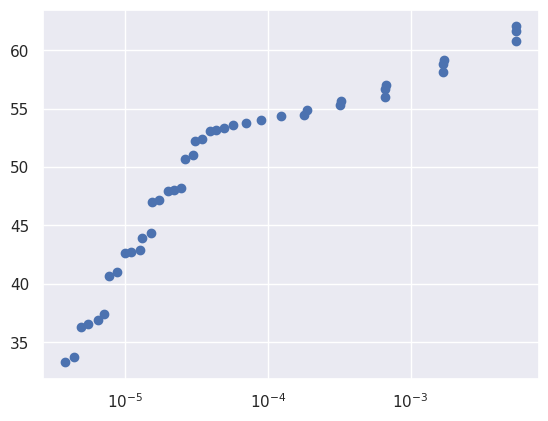

In [73]:
ota1_df["gain"]=20*np.log10(ota1_df["psrr_1stage"])

area = ota1_df["area"]
gain = ota1_df["gain"]

plt.scatter(area, gain)
plt.xscale("log")

In [74]:
W_diff_pf = (ota1_df[Symbol("W_diff")].values*1e6)
L_diff_pf = (ota1_df[Symbol("L_diff")].values*1e6)

W_al_pf = (ota1_df[Symbol("W_aload")].values*1e6)
L_al_pf = (ota1_df[Symbol("L_aload")].values*1e6)

#W_s2_pf = (final_dict[Symbol("W_2stage")].values*1e6)
#L_s2_pf = (final_dict[Symbol("L_2stage")].values*1e6)

mult_diff = []
for idx, i in enumerate(W_diff_pf):
    if i>100:
        mult_diff.append(10)
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al_pf):
    if i>100:
        mult_al.append(10)
    else:
        mult_al.append(1)

values = {
    "XM1": [
        W_diff_pf,
        L_diff_pf,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff_pf,
        L_diff_pf,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "XM4": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "I2": np.full(len(W_diff_pf), Is1*2)
}

simulation_results = spice_sim("ota_tb_ihp", values)

[array([2.05951585e+00, 2.66542899e+00, 2.05951585e+00, 2.66542899e+00,
       3.56255497e+00, 4.02999772e+00, 5.13681639e+00, 7.82275444e+00,
       9.88194269e+00, 2.05951585e+00, 4.02999772e+00, 5.13681639e+00,
       6.72969804e+00, 7.82275444e+00, 9.88194269e+00, 1.54008065e+01,
       1.93698063e+01, 6.45740616e+02, 1.68195976e+03, 5.45738211e+03,
       7.82275444e+00, 9.88194269e+00, 1.28004406e+01, 1.54008065e+01,
       1.93698063e+01, 1.64789412e+02, 3.02708505e+02, 6.45740616e+02,
       1.68195976e+03, 5.45738211e+03, 1.54008065e+01, 1.93698063e+01,
       2.49540896e+01, 3.30978371e+01, 4.55053250e+01, 6.54662913e+01,
       9.98791993e+01, 1.64789412e+02, 3.02708505e+02, 6.45740616e+02,
       1.68195976e+03, 5.45738211e+03]), array([0.8, 0.8, 0.8, 0.8, 0.8, 1.6, 1.6, 3.2, 3.2, 0.8, 1.6, 1.6, 1.6,
       3.2, 3.2, 6.4, 6.4, 6.4, 6.4, 6.4, 3.2, 3.2, 3.2, 6.4, 6.4, 6.4,
       6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4,
       6.4, 6.4, 6.4]), [1, 1, 1

In [75]:
sim_gm_diff = []
sim_gds_diff = []
gain_error = []

for df in simulation_results:
    sim_gm_diff.append(float(df.columns[5]))
    sim_gds_diff.append(float(df.columns[7]))
    gain_error.append(float(df.columns[1]))

ota1_df["gain_sim"]=gain_error
ota1_df["gm_diff_error"] = (np.abs(np.asarray(sim_gm_diff) - ota1_df[Symbol("gdif_1")].values)/np.asarray(sim_gm_diff))*100
ota1_df["gds_diff_error"] = (np.abs(np.asarray(sim_gds_diff) - 1/(ota1_df[Symbol("Rdif_1")].values))/np.asarray(sim_gds_diff))*100
ota1_df["gain_error"] = (np.abs(np.asarray(gain_error) - ota1_df["gain"].values)/np.asarray(gain_error))*100

In [79]:
ota1_df = ota1_df[(ota1_df[Symbol("W_aload")]>5e-6) & (ota1_df[Symbol("W_diff")]>5e-6) & (ota1_df[Symbol("W_diff")]<1000e-6)]
ota1_df

,Rdif_1,gdif_1,Cgd,Cgs,Raload_1,gaload,psrr_1stage,rout_1stage,gm_1stage,W_diff,L_diff,W_aload,L_aload,area,gain,gain_sim,gm_diff_error,gds_diff_error,gain_error,gmid
168,2.741650e+06,0.000111,-6.898742e-17,6.635957e-14,1.252136e+07,0.000046,249.281101,2.258050e+06,0.000110,0.000008,0.000003,0.000006,0.000003,0.000020,47.933787,47.737375,0.728917,1.970306,0.411443,4.437123
169,2.483574e+06,0.000122,-8.878876e-17,8.281855e-14,1.252136e+07,0.000046,253.283776,2.081527e+06,0.000122,0.000010,0.000003,0.000006,0.000003,0.000022,48.072147,47.955223,0.483785,1.138927,0.243820,4.892695
170,2.233005e+06,0.000136,-1.164984e-16,1.057064e-13,1.252136e+07,0.000046,257.600828,1.904230e+06,0.000135,0.000013,0.000003,0.000006,0.000003,0.000025,48.218945,48.172781,0.267140,0.412118,0.095830,5.442044
180,5.334962e+06,0.000109,-1.099623e-16,2.634337e-13,1.252136e+07,0.000046,407.942843,3.748612e+06,0.000109,0.000015,0.000006,0.000006,0.000003,0.000031,52.211986,52.214280,0.181249,0.054820,0.004393,4.365600
181,4.834709e+06,0.000120,-1.398343e-16,3.275682e-13,1.252136e+07,0.000046,418.476387,3.495756e+06,0.000120,0.000019,0.000006,0.000006,0.000003,0.000034,52.433419,52.475649,0.019138,0.482658,0.080475,4.803258
187,2.287235e+06,0.000274,-1.130833e-15,2.291798e-12,1.252136e+07,0.000046,529.137304,1.943111e+06,0.000272,0.000165,0.000006,0.000006,0.000003,0.000180,54.471368,54.688613,0.461958,2.335380,0.397240,10.953561
188,2.008122e+06,0.000337,-1.961294e-15,3.766974e-12,1.252136e+07,0.000046,582.435948,1.739902e+06,0.000335,0.000303,0.000006,0.000006,0.000003,0.000318,55.304963,55.537972,0.446708,2.535907,0.419548,13.473860
189,1.840213e+06,0.000424,-3.769478e-15,6.569507e-12,1.252136e+07,0.000046,680.018584,1.613850e+06,0.000421,0.000646,0.000006,0.000006,0.000003,0.000661,56.650416,56.890268,0.377916,2.687137,0.421605,16.968311
228,5.334962e+06,0.000109,-1.099623e-16,2.634337e-13,1.801366e+07,0.000046,448.948537,4.124265e+06,0.000109,0.000015,0.000006,0.000011,0.000006,0.000039,53.043931,53.010769,0.181834,0.319164,0.062557,4.365600
229,4.834709e+06,0.000120,-1.398343e-16,3.275682e-13,1.801366e+07,0.000046,457.439442,3.820164e+06,0.000120,0.000019,0.000006,0.000011,0.000006,0.000043,53.206672,53.215680,0.019748,0.101706,0.016926,4.803258


In [80]:
ota1_df["gmid"]=ota1_df[Symbol("gdif_1")]/Is1

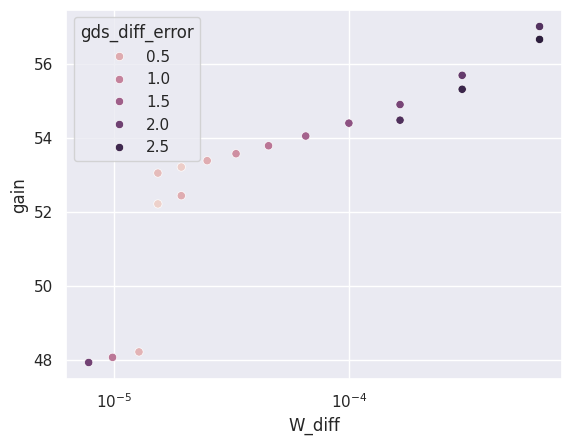

In [81]:
sns.scatterplot(data=ota1_df, x=Symbol("W_diff"), y="gain", hue="gds_diff_error")
plt.xscale("log")

In [82]:
## LDO MACROMODEL

Vg = np.linspace(Vin - (Vin - Vout), 1.8, 5)

LDO_macro = Macromodel(name = "ldo",
                       outputs = [Symbol("W_pt"), Symbol("L_pt")],
                       electrical_parameters = {"Vdd": Vin, 
                                                "Vref": Vref, 
                                                "Vout": Vout, 
                                                "Vaout": 1.7,
                                                "Il": IL} 
                       )

LDO_macro.area_conditions = [10e-3, 0]

## 2stage_OTA MACROMODEL

Vg_ota = np.linspace(LDO_macro.electrical_parameters["Vdd"] - (LDO_macro.electrical_parameters["Vdd"] - LDO_macro.electrical_parameters["Vaout"]), LDO_macro.electrical_parameters["Vdd"], 5)

stage2_OTA_macro = Macromodel(name = "stage2_OTA",
                              outputs=[Symbol("W_diff"), Symbol("L_diff"), Symbol("W_al"), Symbol("L_al"), Symbol("W_2stage"), Symbol("L_2stage")],
                              macromodel_parameters={Symbol('Ra'): np.logspace(3, 7, N_points),
                                                     Symbol('gma'): np.logspace(-5, -2, N_points),
                                                     Symbol('Ca'): np.logspace(-17, -12, N_points)},
                              electrical_parameters = {"Vdd": LDO_macro.electrical_parameters["Vdd"], 
                                                       "Vneg": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vpos": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vout": LDO_macro.electrical_parameters["Vaout"],
                                                       "Vaouts1": 1.6}
                              )
stage2_OTA_macro.area_conditions = [10e-2, 1, 1, 1]

## 1stage_OTA MACROMODEL

OTA_macro = Macromodel(name = "ota_cap",
                       outputs = [Symbol("W_diff"), Symbol("L_diff"), Symbol("W_al"), Symbol("L_al")],
                       req_tfs = [["vout", "vpos"], ["vout", "vpos"]],
                       macromodel_parameters={Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
                                              Symbol('gma_1stage'): np.logspace(-5, -2, N_points),
                                              Symbol('Ca_1stage'): np.logspace(-17, -12, N_points)},
                       electrical_parameters={Symbol("gdif_2"): Symbol("gdif_1"),
                                              Symbol("Rdif_2"): Symbol("Rdif_1")}
                      )

OTA_macro.area_conditions = [10e-3, 1, 1, 1]

In [83]:
W_diff = (ota1_df[Symbol("W_diff")].values)
L_diff = (ota1_df[Symbol("L_diff")].values)

W_al = (ota1_df[Symbol("W_aload")].values)
L_al = (ota1_df[Symbol("L_aload")].values)

#W_s2 = (final_dict[Symbol("W_2stage")].values)
#L_s2 = (final_dict[Symbol("L_2stage")].values)

gm_OTA_macro = ota1_df["gm_1stage"].values
Ro_OTA_macro = ota1_df["rout_1stage"].values

In [84]:
W_al.shape

(18,)

In [85]:
final_OTA = Primitive(parameters={Symbol("Ra_1stage"): Ro_OTA_macro,
                                  Symbol("gma_1stage"): gm_OTA_macro,
                                  Symbol('Ca_1stage'): np.logspace(-17, -12, len(W_diff))})
final_OTA.outputs = {Symbol("W_diff"): W_diff,
                     Symbol("L_diff"): L_diff,
                     Symbol("W_al"): W_al,
                     Symbol("L_al"): L_al}

In [86]:
stage2_OTA_macro.primitives = [final_OTA, stage2_t]
stage2_OTA_macro.submacromodels = []
stage2_OTA_macro.num_level_exp = 1
stage2_OTA_macro.specifications = [psrr_2stage_OTA, rout_2stage_OTA, gm_2stage_OTA]
stage2_OTA_macro.opt_specifications = [psrr_2stage_OTA]
stage2_OTA_macro.is_primitive = 0

ota2_results, ota2_axes, ota2_primouts, ota2_df = dfs(stage2_OTA_macro, debug = False)

############################################
Starting the exploration of:  stage2_OTA
Netlist:  stage2_OTA
Running MNA... 
   net1  vout  Vaout  V_p  V_n  vss
0     1     2      3    4    5    0
[['vout', 'V_p']]
Netlist:  stage2_OTA_r
Running MNA... 
   net1  vout  Vaout  V_p  V_n  vss  vr
0     1     2      3    4    5    0   6
[['vout', 'vr']]
Netlist:  stage2_OTA
Running MNA... 
   net1  vout  Vaout  V_p  V_n  vss
0     1     2      3    4    5    0
[['vout', 'V_p']]
{<sstadex.models.primitives.Primitive object at 0x7ff87d877ee0>: {Ra_1stage: array([2258049.93832967, 2081527.48010171, 1904230.33316399,
       3748612.33936102, 3495756.00825999, 1943111.19052655,
       1739902.18607488, 1613849.85207033, 4124265.23919272,
       3820164.33825692, 3512975.71473642, 3204480.93042901,
       2897321.02467931, 2595558.03321592, 2305738.24005344,
       2039082.37778312, 1816389.68170021, 1679404.99697682]), gma_1stage: array([0.0001104 , 0.00012168, 0.00013528, 0.00010883, 0.00011971,


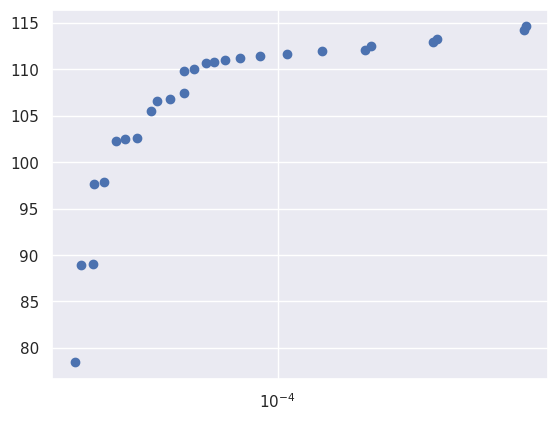

In [87]:
ota2_df["gain"] = 20*np.log10(ota2_df["psrr_2stage"])
area = ota2_df["area"]
psrr = ota2_df["gain"]

plt.scatter(area, psrr)
plt.xscale("log")

In [88]:
W_diff_pf = (ota2_df[Symbol("W_diff")].values*1e6)
L_diff_pf = (ota2_df[Symbol("L_diff")].values*1e6)

W_al_pf = (ota2_df[Symbol("W_al")].values*1e6)
L_al_pf = (ota2_df[Symbol("L_al")].values*1e6)

W_s2_pf = (ota2_df[Symbol("W_2stage")].values*1e6)
L_s2_pf = (ota2_df[Symbol("L_2stage")].values*1e6)

In [89]:
mult_diff = []
for idx, i in enumerate(W_diff_pf):
    if i>100:
        mult_diff.append(10)
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al_pf):
    if i>100:
        mult_al.append(10)
    else:
        mult_al.append(1)

mult_s2 = []
for idx, i in enumerate(W_s2_pf):
    if i>100:
        mult_s2.append(10)
    else:
        mult_s2.append(1)

In [90]:
values = {
    "XM1": [
        W_diff_pf,
        L_diff_pf,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff_pf,
        L_diff_pf,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "XM4": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "XM5": [
        W_s2_pf,
        L_s2_pf,
        mult_s2,
        "pfet",
    ],
    "I2": np.full(len(W_diff_pf), Is1*2),
    "I1": np.full(len(W_diff_pf), Is2)
}

simulation_results = spice_sim("stage2_OTA_tb_ihp", values)

[array([  7.82275444,   7.82275444,   9.88194269,   7.82275444,
         9.88194269,   7.82275444,   9.88194269,  12.80044065,
        15.40080649,  19.36980626,  15.40080649,   7.82275444,
        15.40080649,  19.36980626, 164.78941151, 302.70850548,
       645.74061561,  15.40080649,  19.36980626,  24.95408964,
        33.0978371 ,  45.50532501,  65.46629131,  99.87919927,
       164.78941151, 302.70850548, 645.74061561]), array([3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 6.4, 6.4, 6.4, 3.2, 6.4,
       6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4,
       6.4]), [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 10, 10, 1, 1, 1, 1, 1, 1, 1, 10, 10, 10], 'nfet']
test numer:  0
** sch_path: /workspaces/usm-vlsi-tools/shared_xserver/SSTADEx/test/sstadex/xschem/stage2_OTA_tb_ihp.sch

**.subckt stage2_OTA_tb_ihp

['I2', 'vs', 'vss', '5e-05']
I2 vs vss 5e-05 

['I1', 'vout', 'vss', '2.5e-05']
I1 vout vss 2.5e-05 

C1 vout vss 1e-12 m=1

XM1
['XM1', 'vout_s1', 'vn', 'vs', 'vs',

In [91]:
sim_gm_diff = []
sim_gds_diff = []
gain_sim = []

for df in simulation_results:
    sim_gm_diff.append(float(df.columns[5]))
    sim_gds_diff.append(float(df.columns[7]))
    gain_sim.append(float(df.columns[1]))

ota2_df["gain_error"] = (np.abs(np.asarray(gain_sim) - ota2_df["gain"].values)/np.asarray(gain_sim))*100
ota2_df["gm_diff_error"] = (np.abs(np.asarray(sim_gm_diff) - ota2_df[Symbol("gma_1stage")].values)/np.asarray(sim_gm_diff))*100

In [92]:
#ota2_df = ota2_df[ota2_df[Symbol("W_2stage")]>5e-6]
ota2_df

,Ra_1stage,gma_1stage,Ca_1stage,gm_stage2,Ro_stage2,psrr_2stage,rout_2stage,gm_2stage,W_diff,L_diff,W_al,L_al,W_2stage,L_2stage,area,gain,gain_error,gm_diff_error
0,2.258050e+06,0.000110,1.000000e-17,0.000042,8.076247e+05,8366.603631,8.076247e+05,0.010360,0.000008,0.000003,0.000006,0.000003,5.190942e-07,4.000000e-07,0.000021,78.450984,1.168650,0.238467
18,2.258050e+06,0.000110,1.000000e-17,0.000044,2.532473e+06,27999.590296,2.532473e+06,0.011056,0.000008,0.000003,0.000006,0.000003,1.214406e-06,8.000000e-07,0.000022,88.943034,1.351288,0.242406
19,2.081527e+06,0.000122,1.968419e-17,0.000044,2.532473e+06,28449.176242,2.532473e+06,0.011234,0.000010,0.000003,0.000006,0.000003,1.214406e-06,8.000000e-07,0.000024,89.081394,1.444823,0.042524
36,2.258050e+06,0.000110,1.000000e-17,0.000046,6.750350e+06,76637.888998,6.750350e+06,0.011353,0.000008,0.000003,0.000006,0.000003,2.629945e-06,1.600000e-06,0.000024,97.688871,0.239510,0.244995
37,2.081527e+06,0.000122,1.968419e-17,0.000046,6.750350e+06,77868.454069,6.750350e+06,0.011535,0.000010,0.000003,0.000006,0.000003,2.629945e-06,1.600000e-06,0.000026,97.827231,0.322629,0.039837
54,2.258050e+06,0.000110,1.000000e-17,0.000046,1.135046e+07,130534.699385,1.135046e+07,0.011500,0.000008,0.000003,0.000006,0.000003,5.504686e-06,3.200000e-06,0.000028,102.314519,0.550397,0.246336
55,2.081527e+06,0.000122,1.968419e-17,0.000046,1.135046e+07,132630.678851,1.135046e+07,0.011685,0.000010,0.000003,0.000006,0.000003,5.504686e-06,3.200000e-06,0.000030,102.452880,0.471263,0.038447
56,1.904230e+06,0.000135,3.874675e-17,0.000046,1.135046e+07,134891.279830,1.135046e+07,0.011884,0.000013,0.000003,0.000006,0.000003,5.504686e-06,3.200000e-06,0.000033,102.599678,0.401008,0.302485
57,3.748612e+06,0.000109,7.626986e-17,0.000046,1.135046e+07,213617.062292,1.135046e+07,0.018820,0.000015,0.000006,0.000006,0.000003,5.504686e-06,3.200000e-06,0.000039,106.592719,0.340196,0.107861
58,3.495756e+06,0.000120,1.501311e-16,0.000046,1.135046e+07,219132.895370,1.135046e+07,0.019306,0.000019,0.000006,0.000006,0.000003,5.504686e-06,3.200000e-06,0.000043,106.814152,0.301847,0.290382


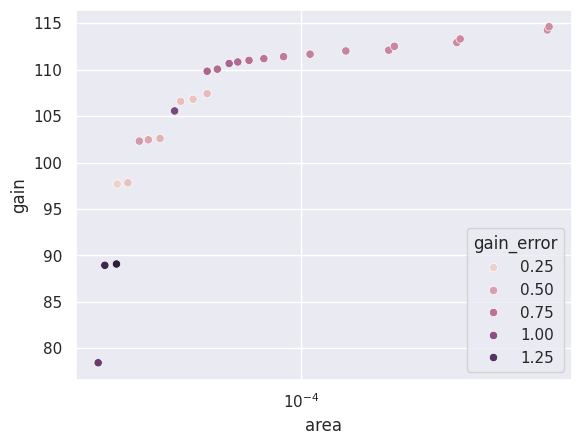

In [93]:
ota2_df["gmid"]=ota2_df[Symbol("gm_stage2")]/20e-6
sns.scatterplot(data=ota2_df, x="area", y="gain", hue="gain_error")
plt.xscale("log")

In [94]:
## LDO MACROMODEL

Vg = np.linspace(Vin - (Vin - Vout), 1.8, 5)

LDO_macro = Macromodel(name = "ldo",
                       outputs = [Symbol("W_diff"), Symbol("L_diff"), Symbol("W_al"), Symbol("L_al"), Symbol("W_2stage"), Symbol("L_2stage"), Symbol("W_pt"), Symbol("L_pt")],
                       electrical_parameters = {"Vdd": Vin, 
                                                "Vref": Vref, 
                                                "Vout": Vout, 
                                                "Vaout": 1.7,
                                                "Il": IL} 
                       )

LDO_macro.area_conditions = [10e-3, 0]

## 2stage_OTA MACROMODEL

Vg_ota = np.linspace(LDO_macro.electrical_parameters["Vdd"] - (LDO_macro.electrical_parameters["Vdd"] - LDO_macro.electrical_parameters["Vaout"]), LDO_macro.electrical_parameters["Vdd"], 5)

stage2_OTA_macro = Macromodel(name = "stage2_OTA",
                              outputs=[Symbol("W_diff"), Symbol("L_diff"), Symbol("W_al"), Symbol("L_al"), Symbol("W_2stage"), Symbol("L_2stage")],
                              macromodel_parameters={Symbol('Ra'): np.logspace(3, 7, N_points),
                                                     Symbol('gma'): np.logspace(-5, -2, N_points),
                                                     Symbol('Ca'): np.logspace(-17, -12, N_points)},
                              electrical_parameters = {"Vdd": LDO_macro.electrical_parameters["Vdd"], 
                                                       "Vneg": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vpos": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vout": LDO_macro.electrical_parameters["Vaout"],
                                                       "Vaouts1": 1.6}
                              )
stage2_OTA_macro.area_conditions = [10e-2, 1, 1, 1]

## 1stage_OTA MACROMODEL

OTA_macro = Macromodel(name = "ota_cap",
                       outputs = [Symbol("W_diff"), Symbol("L_diff"), Symbol("W_al"), Symbol("L_al")],
                       req_tfs = [["vout", "vpos"], ["vout", "vpos"]],
                       macromodel_parameters={Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
                                              Symbol('gma_1stage'): np.logspace(-5, -2, N_points),
                                              Symbol('Ca_1stage'): np.logspace(-17, -12, N_points)},
                       electrical_parameters={Symbol("gdif_2"): Symbol("gdif_1"),
                                              Symbol("Rdif_2"): Symbol("Rdif_1")}
                      )

OTA_macro.area_conditions = [10e-3, 1, 1, 1]

In [95]:
W_diff = (ota2_df[Symbol("W_diff")].values)
L_diff = (ota2_df[Symbol("L_diff")].values)

W_al = (ota2_df[Symbol("W_al")].values)
L_al = (ota2_df[Symbol("L_al")].values)

W_2stage = (ota2_df[Symbol("W_2stage")].values)
L_2stage = (ota2_df[Symbol("L_2stage")].values)

gm_2sOTA_macro = ota2_df["gm_2stage"].values
Ro_2sOTA_macro = ota2_df["rout_2stage"].values

In [96]:
final_2sOTA = Primitive(parameters={Symbol("Ra"): Ro_2sOTA_macro,
                                    Symbol("gma"): gm_2sOTA_macro,
                                    Symbol('Ca'): np.logspace(-17, -12, len(W_diff))})
final_2sOTA.outputs = {Symbol("W_diff"): W_diff,
                       Symbol("L_diff"): L_diff,
                       Symbol("W_al"): W_al,
                       Symbol("L_al"): L_al,
                       Symbol("W_pt"): W_2stage,
                       Symbol("L_pt"): L_2stage}

In [97]:
pt.Ro

array([[ 202.03402242],
       [ 637.71482188],
       [1652.33600827],
       [2733.20528052],
       [3937.45637021]])

In [98]:
LDO_macro.primitives=[final_2sOTA, pt]
LDO_macro.submacromodels=[]
LDO_macro.num_level_exp=1
LDO_macro.specifications=[psrr_LDO_macro]
LDO_macro.opt_specifications=[psrr_LDO_macro]
LDO_macro.is_primitive=0

ldo_results, ldo_axes, ldo_primouts, ldo_df = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  ldo
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
{<sstadex.models.primitives.Primitive object at 0x7ff87daf2fb0>: {Ra: array([  807624.66281042,  2532472.64056902,  2532472.64056902,
        6750349.56978185,  6750349.56978185, 11350458.80551097,
       11350458.80551097, 11350458.80551097, 11350458.80551097,
       11350458.80551097, 11350458.80551097, 16388151.02251091,
       16388151.02251091, 16388151.02251091, 16388151.02251091,
       16388151.02251091, 16388151.02251091, 16388151.02251091,
       16388151.02251091, 16388151.02251091, 16388151.02251091,
       16388151.02251091, 16388151.02251091, 16388151.02251091,
       16388151.02251091, 16388151.02251091, 16388151.02251091]), gma: array([0.01035952, 0.01105623, 0.01123375, 0.01135317, 0.01153547,
       0.01150039, 0.01168505, 0.01188421, 0.01882013, 0.01930608,
       0.0207118

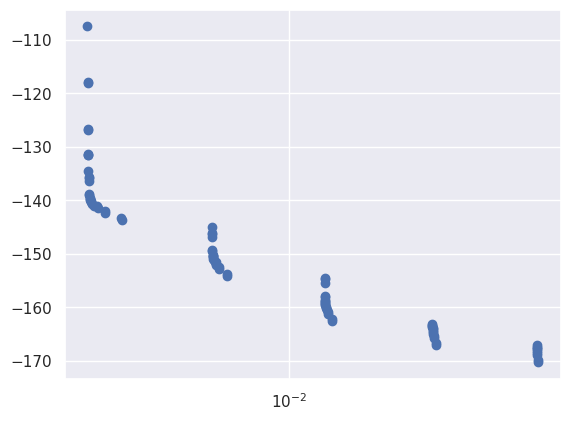

In [99]:
ldo_df["gain"] = 20*np.log10(ldo_df["psrr_LDO"])

area = ldo_df["area"]
psrr = ldo_df["gain"]

plt.scatter(area, psrr)
plt.xscale("log")

In [100]:
ldo_df

,Ra,gma,Ca,gm_pt,Ro_pt,psrr_LDO,W_diff,L_diff,W_al,L_al,W_2stage,L_2stage,W_pt,L_pt,area,gain
0,8.076247e+05,0.010360,1.000000e-17,0.185844,202.034022,4.244191e-06,0.000008,0.000003,0.000006,0.000003,5.190942e-07,4.000000e-07,0.002488,4.000000e-07,0.002509,-107.444102
1,2.532473e+06,0.011056,1.557068e-17,0.185844,202.034022,1.268260e-06,0.000008,0.000003,0.000006,0.000003,1.214406e-06,8.000000e-07,0.002488,4.000000e-07,0.002510,-117.935836
2,2.532473e+06,0.011234,2.424462e-17,0.185844,202.034022,1.248218e-06,0.000010,0.000003,0.000006,0.000003,1.214406e-06,8.000000e-07,0.002488,4.000000e-07,0.002512,-118.074194
3,6.750350e+06,0.011353,3.775053e-17,0.185844,202.034022,4.633622e-07,0.000008,0.000003,0.000006,0.000003,2.629945e-06,1.600000e-06,0.002488,4.000000e-07,0.002512,-126.681588
4,6.750350e+06,0.011535,5.878016e-17,0.185844,202.034022,4.560397e-07,0.000010,0.000003,0.000006,0.000003,2.629945e-06,1.600000e-06,0.002488,4.000000e-07,0.002514,-126.819947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,1.638815e+07,0.023389,1.701254e-13,0.206561,3937.456370,4.276863e-09,0.000065,0.000006,0.000011,0.000006,1.127658e-05,6.400000e-06,0.054876,6.400000e-06,0.054990,-167.377492
131,1.638815e+07,0.024344,2.648969e-13,0.206561,3937.456370,4.109193e-09,0.000100,0.000006,0.000011,0.000006,1.127658e-05,6.400000e-06,0.054876,6.400000e-06,0.055024,-167.724868
132,1.638815e+07,0.025791,4.124626e-13,0.206561,3937.456370,3.878615e-09,0.000165,0.000006,0.000011,0.000006,1.127658e-05,6.400000e-06,0.054876,6.400000e-06,0.055089,-168.226466
133,1.638815e+07,0.028242,6.422325e-13,0.206561,3937.456370,3.541997e-09,0.000303,0.000006,0.000011,0.000006,1.127658e-05,6.400000e-06,0.054876,6.400000e-06,0.055227,-169.015036


In [101]:
W_diff_pf = (ldo_df[Symbol("W_diff")].values*1e6)
L_diff_pf = (ldo_df[Symbol("L_diff")].values*1e6)

W_al_pf = (ldo_df[Symbol("W_al")].values*1e6)
L_al_pf = (ldo_df[Symbol("L_al")].values*1e6)

W_s2_pf = (ldo_df[Symbol("W_2stage")].values*1e6)
L_s2_pf = (ldo_df[Symbol("L_2stage")].values*1e6)

W_pt = (ldo_df[Symbol("W_pt")].values*1e6)
L_pt = (ldo_df[Symbol("L_pt")].values*1e6)

In [102]:
mult_diff = []
for idx, i in enumerate(W_diff_pf):
    if i>100:
        mult_diff.append(10)
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al_pf):
    if i>100:
        mult_al.append(10)
    else:
        mult_al.append(1)

mult_s2 = []
for idx, i in enumerate(W_s2_pf):
    if i>100:
        mult_s2.append(10)
    else:
        mult_s2.append(1)

mult_pt = []
for idx, i in enumerate(W_pt):
    if i>10000:
        mult_pt.append(1000)
    else:
        mult_pt.append(1)

In [103]:
values = {
    "XM1": [
        W_diff_pf,
        L_diff_pf,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff_pf,
        L_diff_pf,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "XM4": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "XM5": [
        W_s2_pf,
        L_s2_pf,
        mult_s2,
        "pfet",
    ],
    "XM6": [
        W_pt,
        L_pt,
        mult_pt,
        "pfet",
    ],
    "I2": np.full(len(W_diff_pf), Is1*2),
    "I1": np.full(len(W_diff_pf), Is2)
}

simulation_results = spice_sim("ldo_sim_ihp", values)

[array([  7.82275444,   7.82275444,   9.88194269,   7.82275444,
         9.88194269,   7.82275444,   9.88194269,  12.80044065,
        15.40080649,  19.36980626,  15.40080649,   7.82275444,
        15.40080649,  19.36980626, 164.78941151, 302.70850548,
       645.74061561,  15.40080649,  19.36980626,  24.95408964,
        33.0978371 ,  45.50532501,  65.46629131,  99.87919927,
       164.78941151, 302.70850548, 645.74061561,  15.40080649,
        19.36980626,  15.40080649,   7.82275444,  15.40080649,
        19.36980626, 164.78941151, 302.70850548, 645.74061561,
        15.40080649,  19.36980626,  24.95408964,  33.0978371 ,
        45.50532501,  65.46629131,  99.87919927, 164.78941151,
       302.70850548, 645.74061561,  15.40080649,  19.36980626,
        15.40080649,  15.40080649,  19.36980626, 164.78941151,
       302.70850548, 645.74061561,  15.40080649,  19.36980626,
        24.95408964,  33.0978371 ,  45.50532501,  65.46629131,
        99.87919927, 164.78941151, 302.70850548, 645.7

In [104]:
sim_gm_diff = []
sim_gds_diff = []
gain_sim = []

for df in simulation_results:
    sim_gm_diff.append(float(df.columns[5]))
    sim_gds_diff.append(float(df.columns[7]))
    gain_sim.append(float(df.columns[1]))

ldo_df["gain_sim"] = gain_sim
ldo_df["gain_error"] = (np.abs(np.asarray(gain_sim) - ldo_df["gain"].values)/np.asarray(gain_sim))*100


In [119]:
#ldo_df = ldo_df[ldo_df[Symbol("W_2stage")]>5e-6]
ldo_df[(ldo_df[Symbol("W_al")]>10e-6) & (ldo_df[Symbol("W_diff")]>10e-6) & (ldo_df[Symbol("W_diff")]<200e-6) ]

,Ra,gma,Ca,gm_pt,Ro_pt,psrr_LDO,W_diff,L_diff,W_al,L_al,W_2stage,L_2stage,W_pt,L_pt,area,gain,gain_sim,gain_error
10,1.135046e+07,0.020712,8.376776e-16,0.185844,202.034022,1.510541e-07,0.000015,0.000006,0.000011,0.000006,0.000006,0.000003,0.002488,4.000000e-07,0.002536,-136.417348,-101.097116,-34.936933
17,1.638815e+07,0.020846,1.858792e-14,0.185844,202.034022,1.039454e-07,0.000015,0.000006,0.000011,0.000006,0.000011,0.000006,0.002488,4.000000e-07,0.002545,-139.663893,-138.260500,-1.015035
18,1.638815e+07,0.021241,2.894266e-14,0.185844,202.034022,1.020160e-07,0.000019,0.000006,0.000011,0.000006,0.000011,0.000006,0.002488,4.000000e-07,0.002549,-139.826633,-138.421659,-1.014996
19,1.638815e+07,0.021665,4.506570e-14,0.185844,202.034022,1.000181e-07,0.000025,0.000006,0.000011,0.000006,0.000011,0.000006,0.002488,4.000000e-07,0.002555,-139.998429,-138.584986,-1.019911
20,1.638815e+07,0.022138,7.017038e-14,0.185844,202.034022,9.788098e-08,0.000033,0.000006,0.000011,0.000006,0.000011,0.000006,0.002488,4.000000e-07,0.002563,-140.186034,-138.755069,-1.031288
21,1.638815e+07,0.022693,1.092601e-13,0.185844,202.034022,9.548831e-08,0.000046,0.000006,0.000011,0.000006,0.000011,0.000006,0.002488,4.000000e-07,0.002575,-140.400996,-138.937952,-1.053019
22,1.638815e+07,0.023389,1.701254e-13,0.185844,202.034022,9.264397e-08,0.000065,0.000006,0.000011,0.000006,0.000011,0.000006,0.002488,4.000000e-07,0.002595,-140.663657,-139.137068,-1.097183
23,1.638815e+07,0.024344,2.648969e-13,0.185844,202.034022,8.901196e-08,0.000100,0.000006,0.000011,0.000006,0.000011,0.000006,0.002488,4.000000e-07,0.002630,-141.011033,-139.333376,-1.204059
24,1.638815e+07,0.025791,4.124626e-13,0.185844,202.034022,8.401726e-08,0.000165,0.000006,0.000011,0.000006,0.000011,0.000006,0.002488,4.000000e-07,0.002695,-141.512630,-139.382666,-1.528141
37,1.135046e+07,0.020712,8.376776e-16,0.197630,637.714822,4.500145e-08,0.000015,0.000006,0.000011,0.000006,0.000006,0.000003,0.005867,8.000000e-07,0.005916,-146.935471,-101.208741,-45.180613


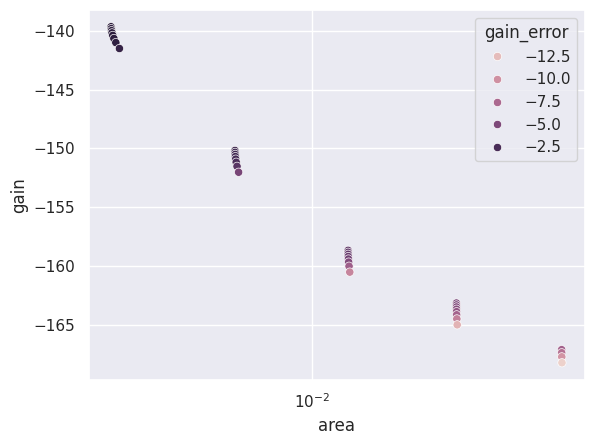

In [117]:
#ota1_df["gmid"]=ota1_df[Symbol("gdif_1")]/20e-6
sns.scatterplot(data=ldo_df[(ldo_df[Symbol("W_al")]>10e-6) & (ldo_df[Symbol("W_diff")]>10e-6) & (ldo_df[Symbol("W_diff")]<200e-6) & (ldo_df[Symbol("W_2stage")]>10e-6)], x="area", y="gain", hue="gain_error")
plt.xscale("log")